## Put all files in a folder with the family as a prefix

In [ ]:
import os
from rouskinhf import convert
import pandas as pd

path = 'data/RNAstralign/'

def fetch(path, prefix=''):
    for filename in os.listdir(path):
        file = os.path.join(path, filename)
        if os.path.isdir(file):
            fetch(file, prefix+filename+'__')
        else:
            if filename.endswith('.ct'):
                filename = filename.replace('(', '_').replace(')', '_')   
                os.system(cmd:=f'cp "{file}" data/RNAstralign_flatten/{prefix}####{filename}')
fetch(path)

## Run RouskinHF on the folder

In [2]:
# !pip install /Users/yvesmartin/src/rouskinhf
from rouskinhf import convert
data = convert(
                'ct',
                'data/RNAstralign_flatten',
                name='RNAstralign',
                filter=True
            )

Parsing ct files: 100%|██████████| 37149/37149 [00:24<00:00, 1517.60it/s]


Over a total of 37149 datapoints, there are:
### OUTPUT
- ALL: 27125 valid datapoints
- INCLUDED: 104 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 3949 invalid datapoints (ex: sequence with non-regular characters)
- 9 datapoints with bad structures
- 6066 duplicate sequences with the same structure / dms / shape


## Rename the refs so that the family as an attribute of the json

In [3]:
new_data = {}
refs = {}
for ref, attr in data.items():
    if '__####' in ref:
        family, ref = ref.split('__####')
        attr['family'] = family
    if not ref in refs:
        refs[ref] = 0
    else:
        while f'{ref}_{refs[ref]}' in refs:
            refs[ref] += 1
        ref = f'{ref}_{refs[ref]}'
    new_data[ref] = attr
    
import json
with open('data/RNAstralign/data.json', 'w') as f:
    f.write('{\n')
    for idx, (ref, attr) in enumerate(new_data.items()):
        f.write(json.dumps({ref: attr})[1:-1])
        if idx < len(new_data)-1:
            f.write(',\n')
    f.write('\n}')
    

## Visualise



<AxesSubplot: >

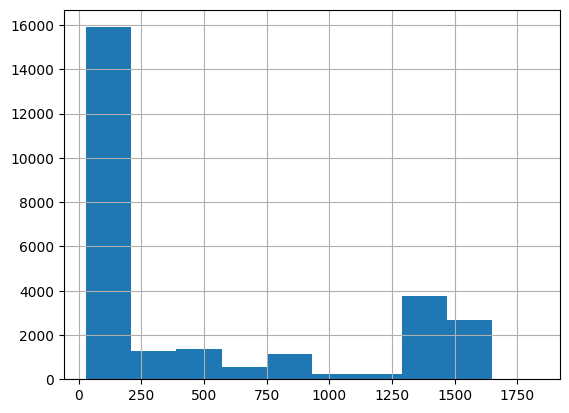

In [4]:
import pandas as pd

df = pd.DataFrame.from_dict(new_data, orient='index')
df.sequence.apply(len).hist(bins=10)

## Upload

In [7]:

from rouskinhf import upload_dataset
import envbash
envbash.load.load_envbash('../.env')

upload_dataset(
    'data/RNAstralign/data.json',
    commit_message='fixed name duplicate error',
    exist_ok=True
)

data.json:   0%|          | 0.00/65.0M [00:00<?, ?B/s]

## Non canonical bases

In [ ]:
import os
from rouskinhf import convert
import pandas as pd

def has_noncanonical(sequence, structure):

    for pair in structure:
        pair = [sequence[pair[0]], sequence[pair[1]]]
        pair.sort()
        if ''.join(pair) not in ['AU', 'UA', 'CG', 'GC', 'GU', 'UG']:
            return True

    return False

non_canonical_data = pd.DataFrame(new_data).T

non_canonical_data['has_noncanonical'] = non_canonical_data.apply(lambda x: has_noncanonical(x.sequence, x.structure), axis=1)
non_canonical_data = non_canonical_data[non_canonical_data["has_noncanonical"]].drop(columns=['has_noncanonical'])

In [ ]:
from rouskinhf import get_dataset

efold_train = get_dataset('efold_train', force_download=True)
efold_train = pd.DataFrame(efold_train).T[['sequence', 'structure']]
efold_train.sequence

In [ ]:
## Filter out sequences that are in training set

non_canonical_data = non_canonical_data[~non_canonical_data['sequence'].isin(efold_train.sequence)]

non_canonical_sequences = non_canonical_data.sequence.tolist()
efold_sequences = efold_train.sequence.tolist()

from tqdm import tqdm
import numpy as np
from Levenshtein import ratio


similarity_matrix = np.zeros((len(non_canonical_sequences), len(efold_sequences))) 
for i, seq1 in tqdm(enumerate(non_canonical_sequences), total=len(non_canonical_sequences)):
    for j, seq2 in enumerate(efold_sequences):
        similarity_matrix[i, j] = ratio(seq1, seq2)

max_similarity = np.max(similarity_matrix, axis=1)


100%|██████████| 5916/5916 [2:56:45<00:00,  1.79s/it]  


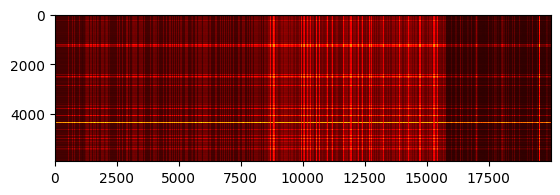

In [30]:
import matplotlib.pyplot as plt

plt.imshow(similarity_matrix[:,:20000], cmap='hot', interpolation='nearest', vmin=0, vmax=1)

In [65]:
threshold = 0.9
np.sort(max_similarity)[1000], sum(max_similarity<threshold)

(0.9191637630662021, 594)

In [54]:
## Random sequences similarity

similarities = []
for _ in range(10000):

    len1 = np.random.randint(10, 1500)
    seq1 = ''.join(np.random.choice(['A', 'U', 'G', 'C'], len1))

    len2 = np.random.randint(10, 1500)
    seq2 = ''.join(np.random.choice(['A', 'U', 'G', 'C'], len2))

    similarities.append(ratio(seq1, seq2))

print(np.mean(similarities), np.std(similarities), np.max(similarities), np.min(similarities))

0.4978451164180562 0.173423566476389 0.6681222707423581 0.015048908954100826


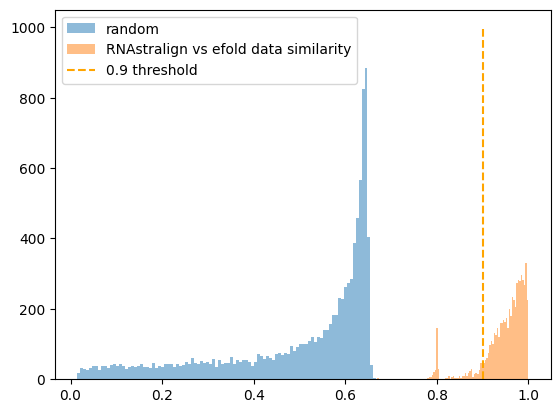

In [66]:
plt.hist(similarities, bins=100, alpha=0.5, label='random')
plt.hist(max_similarity, bins=100, alpha=0.5, label='RNAstralign vs efold data similarity')
plt.vlines(threshold, 0, 1000, color='orange', label=f'{threshold} threshold', linestyle='--')
plt.legend()
plt.show()

In [ ]:
non_canonical_data = non_canonical_data[max_similarity<threshold]
non_canonical_data['similarity'] = max_similarity[max_similarity<threshold]

In [73]:
## Output

path_out = 'data/RNAstralign_non_canonical'
if not os.path.exists(path_out): os.mkdir(path_out)
path_out = os.path.join(path_out, 'data.json')

non_canonical_data.T.to_json(path_out, indent=1)

## Upload
from rouskinhf import upload_dataset
import envbash
envbash.load.load_envbash('../.env')

upload_dataset(
    path_out,
    commit_message='removed similar sequences to efold data',
    exist_ok=True
)

data.json:   0%|          | 0.00/6.19M [00:00<?, ?B/s]